In [46]:
from drn_interactions.load import load_waveforms, load_derived_generic, load_neurons
from drn_interactions.wavemap import connectivity

from umap import UMAP
import community
import umap.plot
import networkx as nx

from sklearn.preprocessing import (
    MinMaxScaler, 
    RobustScaler, 
    StandardScaler,
    QuantileTransformer,
    PowerTransformer,
)
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation



import seaborn as sns
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d


import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go



In [193]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [194]:
clusters = load_derived_generic("clusters.csv")
df = load_waveforms().pivot(index="waveform_index", columns="neuron_id", values="waveform_value")

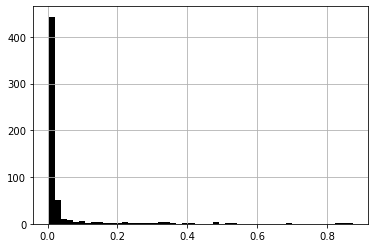

In [385]:
df1 = df.apply(gaussian_filter1d, sigma=3)
scaled = pd.DataFrame(MinMaxScaler().fit_transform(df1), columns=df.columns, index=df.index)
sig_noise = scaled.loc[lambda x: x.index < 100].apply(variation).astype(float)
sig_noise.hist(bins=50, color="black")
bad_neurons = sig_noise[sig_noise > 0.05].index.values
df1 = df1[[c for c in df.columns if c not in bad_neurons]]

In [386]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(MinMaxScaler(), StandardScaler(with_std=False))
pipe2 = MinMaxScaler()

scaled = pd.DataFrame(
    pipe.fit_transform(df1.values), 
    columns=df1.columns, 
    index=df1.index
    )

In [387]:
X = scaled.transpose()

mod = UMAP(n_neighbors=8, min_dist=0, random_state=1).fit(X)
out = pd.DataFrame(mod.embedding_, columns=["d1", "d2"], index=X.index).reset_index()
out2 = out.merge(clusters)
px.scatter(out2, x="d1", y="d2", color="no_wf_3")

In [388]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_samples=20, cluster_selection_epsilon=1) 
clusterer.fit(mod.embedding_)

out["hdb"] = clusterer.labels_
px.scatter(out, x="d1", y="d2", color="hdb")

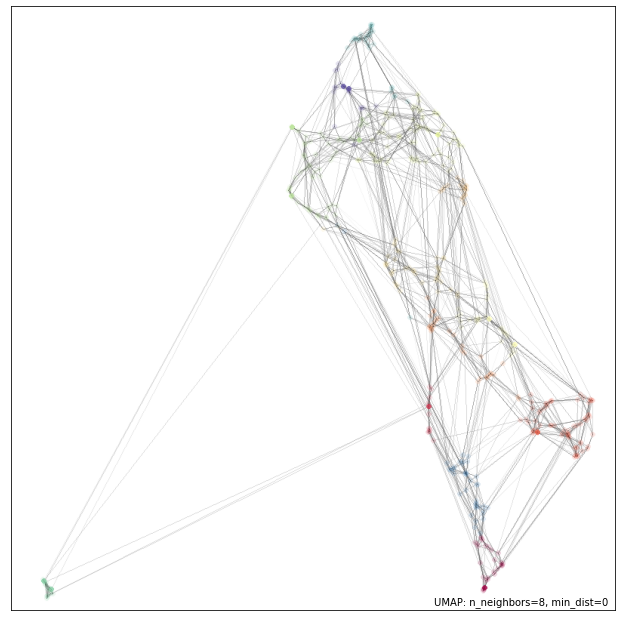

In [389]:
node_mapper = out["neuron_id"].to_dict()

G = nx.from_scipy_sparse_matrix(mod.graph_)
G = nx.relabel_nodes(G, mapping=node_mapper)
partition  = community.best_partition(G, resolution=1, random_state=1)


out["louvain"] = out.neuron_id.map(partition)

connectivity(mod, values=out["louvain"], show_points=True,
     px_size=50, threshold=0.92, cmap="Spectral")
    
px.scatter(out, x="d1", y="d2", color="louvain")

In [292]:
from sklearn.metrics import adjusted_mutual_info_score

In [399]:
out["d1"].min()

-0.15798786

In [391]:
adjusted_mutual_info_score(out["louvain"].values, out["hdb"].values)

0.5997167511419956

In [409]:
corners.shape

(4, 2)

In [408]:
d1 = out["d1"]
d2 = out["d2"]

corners = np.array(
    [out.d1.min(), out.d1.min(), out.d1.max(), out.d1.max(),
    out.d2.min(), out.d2.min(), out.d2.max(), out.d2.max()],
).reshape(4, 2)



# corners = np.array([
#     [-5, -10],  # 1
#     [-7, 6],  # 7
#     [2, -8],  # 2
#     [12, 4],  # 0
# ])




test_pts = np.array([
    (corners[0]*(1-x) + corners[1]*x)*(1-y) +
    (corners[2]*(1-x) + corners[3]*x)*y
    for y in np.linspace(0, 1, 10)
    for x in np.linspace(0, 1, 10)
])

In [446]:
x = np.linspace(out.d1.min() + 5, out.d1.max(), 10)
y = np.linspace(out.d2.min(), out.d2.max(), 10)
x, y = np.meshgrid(x, y)
positions = np.vstack([x.ravel(), y.ravel()])

In [447]:
pos = positions.T

inv_transformed_points = mod.inverse_transform(pos)

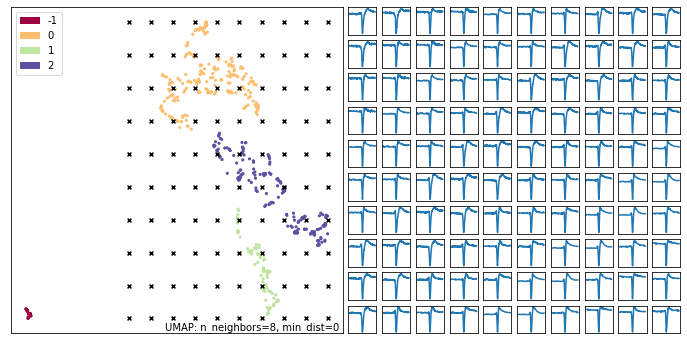

In [448]:
from matplotlib.gridspec import GridSpec

labels = out["hdb"].values

fig = plt.figure(figsize=(12,6))

gs = GridSpec(10, 20, fig)

scatter_ax = fig.add_subplot(gs[:, :10])
digit_axes = np.zeros((10, 10), dtype=object)
for i in range(10):
    for j in range(10):
        digit_axes[i, j] = fig.add_subplot(gs[i, 10 + j])

# Use umap.plot to plot to the major axis

umap.plot.points(mod, labels=labels, ax=scatter_ax)
scatter_ax.scatter(mod.embedding_[:, 0], mod.embedding_[:, 1],
                   c=labels.astype(np.int32), cmap='Spectral', s=0.1)
# scatter_ax.set(xticks=[], yticks=[])

# # Plot the locations of the text points
scatter_ax.scatter(positions[0, :], positions[1, :], marker='x', c='k', s=15)


for i in range(10):
    for j in range(10):
        digit_axes[i, j].plot(inv_transformed_points[i + j, :])
        digit_axes[i, j].set(xticks=[], yticks=[])

In [422]:
test_pts[0, :]

array([-0.15798786, -0.15798786], dtype=float32)

In [436]:
inv_transformed_points.shape

(100, 240)

In [437]:
df.shape

(240, 566)

In [438]:
df

neuron_id,1,4,5,6,8,9,12,17,18,22,...,2622,2623,2624,2625,2626,2627,2628,2629,2630,2634
waveform_index,,,,,,,,,,,,,,,,,,,,,
0.0,-14.5200,-9.30827,-4.3400,0.7450,0.1675,-4.1850,-4.2350,-5.0450,-4.0050,-1.2025,...,1575.35,506.855,502.835,-182.152,-86.6800,3.1275,-31.2450,40.8375,366.560,68.3925
1.0,-13.0850,-13.19800,-5.3100,-1.5625,-0.0975,-3.5350,-4.3800,-6.5875,-2.0925,-3.8050,...,1739.00,504.265,504.277,-179.735,-84.8350,2.5950,-31.7425,43.8700,365.138,69.3725
2.0,-11.7300,-15.05510,-4.7650,-2.7650,-3.7625,-3.9950,-3.1775,-7.9300,-4.2300,-1.9700,...,2066.55,503.728,502.420,-179.180,-87.1500,6.4650,-31.4575,41.3050,364.953,70.4100
3.0,-9.6750,-15.57390,-2.2900,-0.5500,-2.2450,-3.3100,-5.4975,-7.8175,-4.3500,-2.0575,...,1573.76,506.867,505.812,-183.473,-87.2100,7.6125,-27.2875,39.5250,365.277,68.3975
4.0,-7.2750,-14.92230,-3.6325,3.6825,0.3325,-2.2100,-4.7200,-3.8425,-6.1375,-0.4675,...,1573.38,505.270,507.560,-182.955,-84.8175,1.1300,-24.6725,39.4150,365.557,71.2650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235.0,1.8375,-12.62910,9.4250,0.5650,6.0000,13.1700,-0.0550,3.2100,1.3525,5.6675,...,2911.84,533.175,533.343,-179.458,-83.1225,-5.2275,-28.2650,45.1825,195.840,71.5425
236.0,0.1400,-11.81700,5.6550,0.6500,4.1750,13.2375,-2.0375,5.9825,0.7675,9.3700,...,2908.39,531.975,534.432,-177.738,-83.4975,-7.0500,-25.5500,47.7275,200.450,69.3950
237.0,0.5850,-10.24560,4.6275,-4.4425,4.5300,11.7900,-0.7775,5.6825,0.8700,6.7100,...,3072.45,530.825,531.953,-178.087,-83.2075,-8.5025,-25.6900,48.0125,197.303,71.4775
